In [1]:
from google.colab import files
uploaded = files.upload()


Saving kano_covid19_daily_trends.csv to kano_covid19_daily_trends.csv


In [3]:
import pandas as pd

# Replace with your actual filename
df = pd.read_csv('kano_covid19_daily_trends.csv')
df.head()


,Date,Confirmed,Discharged,Deaths
0,27/04/2020,2,0,0
1,28/04/2020,4,0,0
2,29/04/2020,16,0,0
3,30/04/2020,21,0,0
4,01/05/2020,92,0,1


In [5]:
!pip install keras-tcn --quiet


In [7]:
!pip install git+https://github.com/philipperemy/keras-tcn.git --quiet


  Preparing metadata (setup.py) ... done


In [9]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras import Input, Model

def residual_block(x, filters, kernel_size, dilation_rate):
    # First conv
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    # Second conv
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    conv2 = BatchNormalization()(conv2)

    # Residual connection
    res = Add()([x, conv2])
    res = Activation('relu')(res)
    return res



In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('kano_covid19_daily_trends.csv')  # Make sure the filename is correct
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select relevant columns
data = df[['Confirmed', 'Discharged', 'Deaths']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for time series
X = []
y = []
window_size = 14

for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i + window_size])
    y.append(scaled_data[i + window_size])

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



<ipython-input-12-7c4168ba3503>:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [14]:
def residual_block(x, filters, kernel_size, dilation_rate):
    # Shortcut: adjust shape if needed
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(x)

    # First convolution
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    # Second convolution
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    conv2 = BatchNormalization()(conv2)

    # Add shortcut connection
    res = Add()([shortcut, conv2])
    res = Activation('relu')(res)
    return res


In [15]:
tcn_model = build_tcn_model(X.shape[1:], 3)
tcn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
tcn_pred = tcn_model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = pd.read_csv('kano_covid19_daily_trends.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Confirmed', 'Discharged', 'Deaths']]

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
X, y = [], []
window_size = 14
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size])
X, y = np.array(X), np.array(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


<ipython-input-16-dea7adc7bb7f>:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [17]:
def evaluate_and_plot(true_scaled, pred_scaled, model_name):
    # Inverse transform
    true = scaler.inverse_transform(true_scaled)
    pred = scaler.inverse_transform(pred_scaled)

    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)

    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    labels = ['Confirmed', 'Discharged', 'Deaths']
    for i in range(3):
        plt.figure(figsize=(10, 4))
        plt.plot(true[:, i], label='Actual')
        plt.plot(pred[:, i], label='Predicted')
        plt.title(f'{model_name} - {labels[i]}')
        plt.xlabel('Days')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.show()


TCN - MSE: 420.6181, MAE: 14.2503


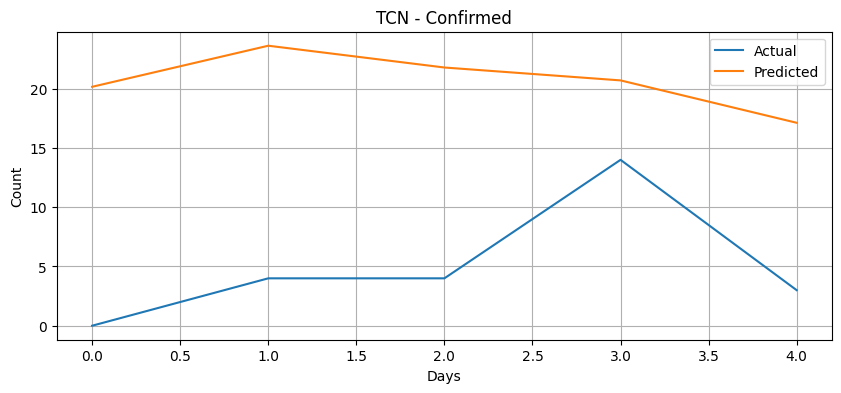

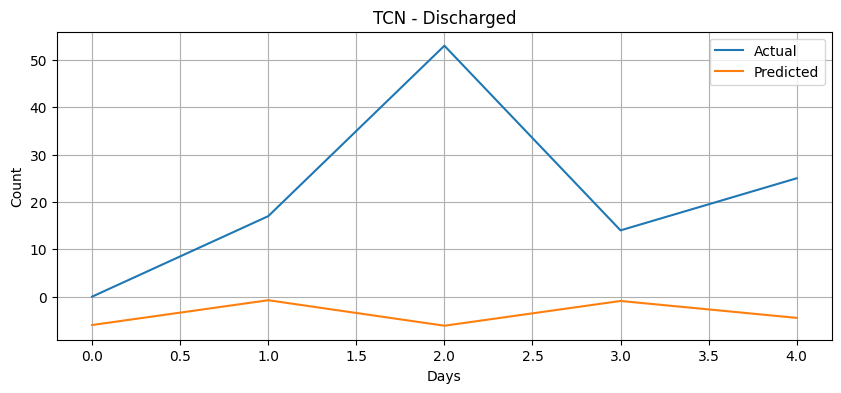

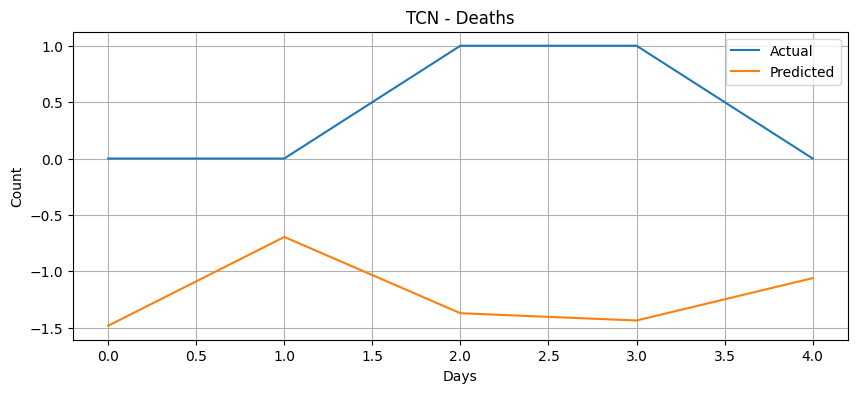

In [18]:
evaluate_and_plot(y_test, tcn_pred, "TCN")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
LSTM - MSE: 140.8704, MAE: 7.2747


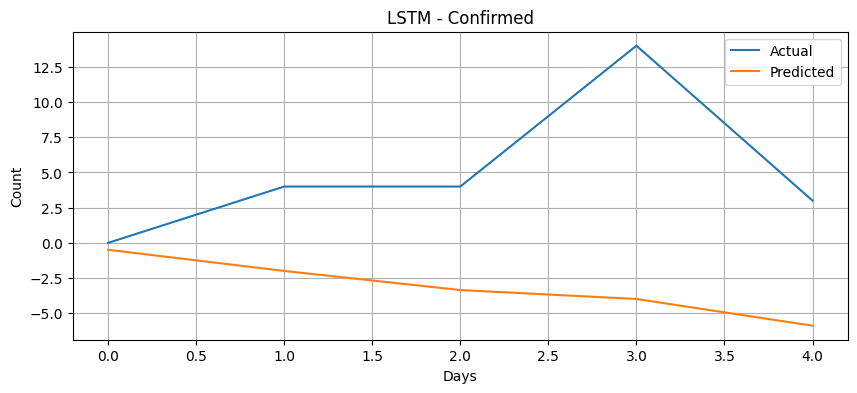

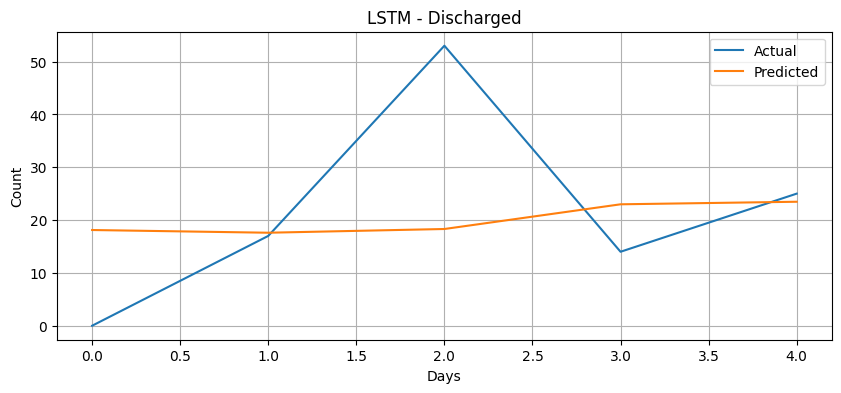

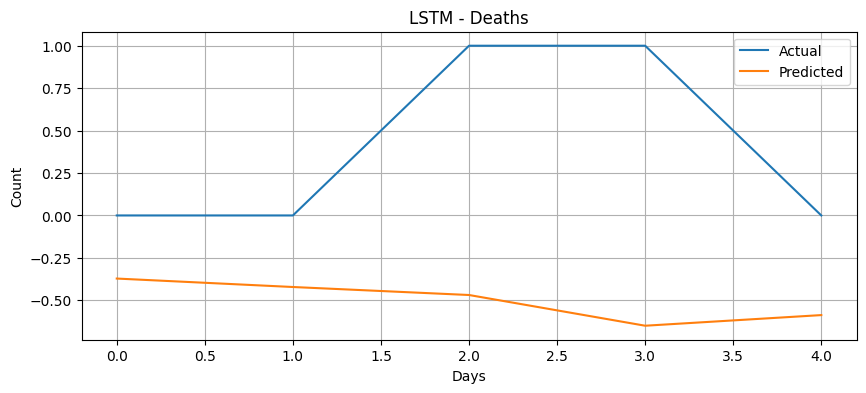

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
lstm_pred = lstm_model.predict(X_test)

evaluate_and_plot(y_test, lstm_pred, "LSTM")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
GRU - MSE: 128.7023, MAE: 6.9265


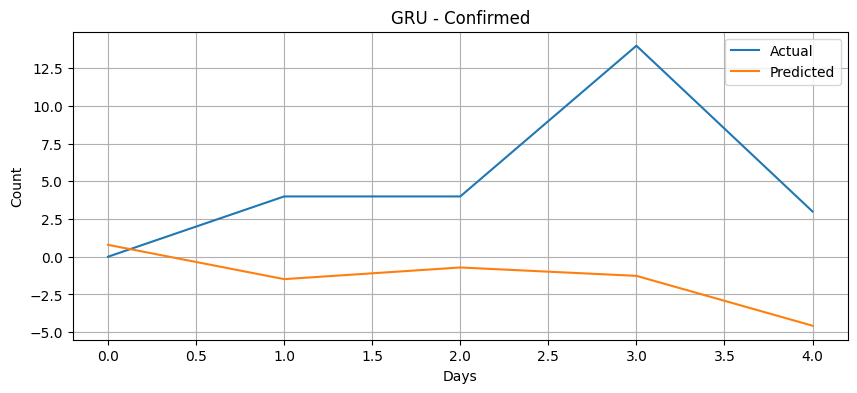

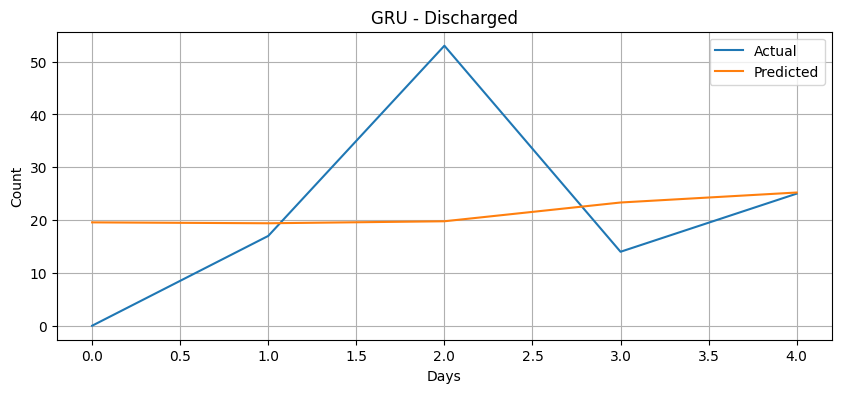

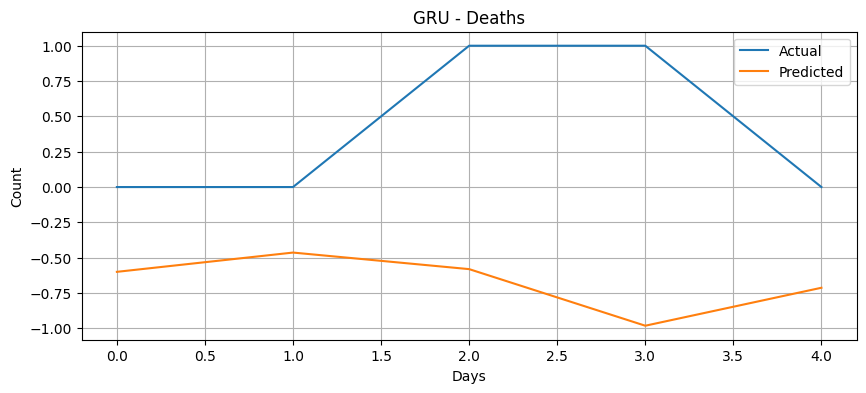

In [20]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
gru_model.add(Dense(3))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
gru_pred = gru_model.predict(X_test)

evaluate_and_plot(y_test, gru_pred, "GRU")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
CNN - MSE: 143.6038, MAE: 6.2197


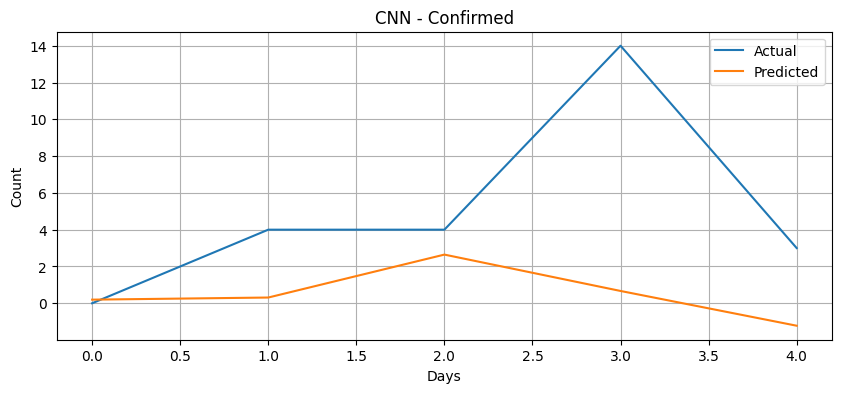

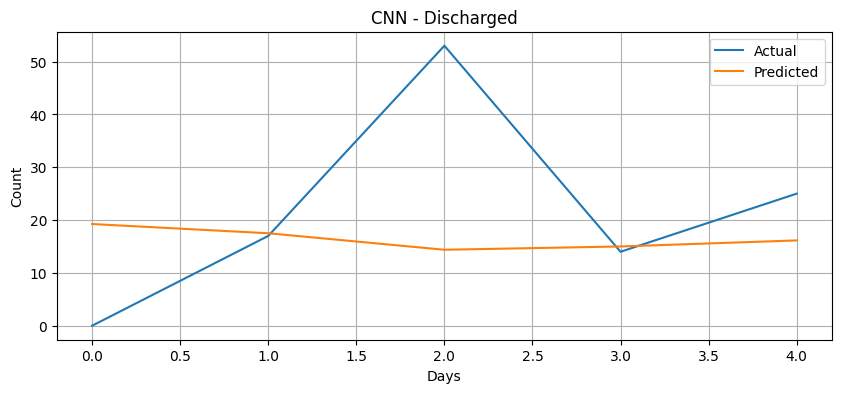

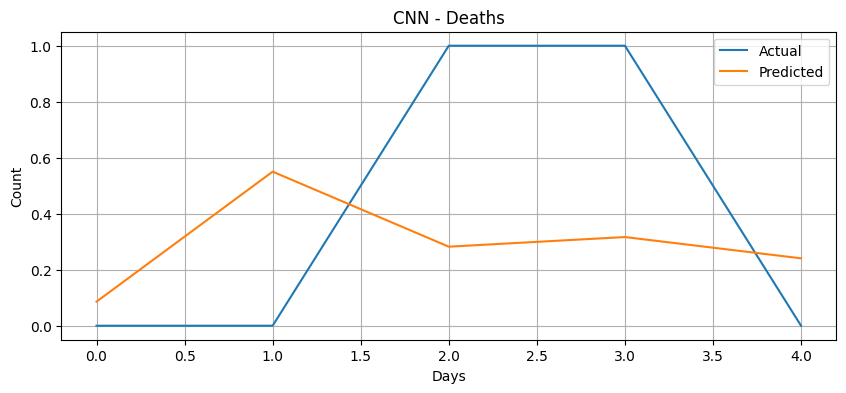

In [21]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(3))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
cnn_pred = cnn_model.predict(X_test)

evaluate_and_plot(y_test, cnn_pred, "CNN")


In [23]:
# Store predictions and labels
model_results = {
    "TCN": tcn_pred,
    "LSTM": lstm_pred,
    "GRU": gru_pred,
    "CNN": cnn_pred
}

# Compare MSE and MAE
results_summary = []

for name, pred in model_results.items():
    true = scaler.inverse_transform(y_test)
    predicted = scaler.inverse_transform(pred)

    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    results_summary.append((name, mse, mae))

# Sort by lowest MSE
results_summary.sort(key=lambda x: x[1])

# Display results
print("Model Performance Comparison:")
print(f"{'Model':<10} {'MSE':<15} {'MAE':<15}")
print("-" * 40)
for name, mse, mae in results_summary:
    print(f"{name:<10} {mse:<15.4f} {mae:<15.4f}")

# Best model
best_model = results_summary[0][0]
print(f"\n The best performing model is: **{best_model}** (lowest MSE)")


Model Performance Comparison:
Model      MSE             MAE            
----------------------------------------
GRU        128.7023        6.9265         
LSTM       140.8704        7.2747         
CNN        143.6038        6.2197         
TCN        420.6181        14.2503        

 The best performing model is: **GRU** (lowest MSE)
